In [137]:
import numpy as np
import matplotlib.pyplot as plt

from signal_tl import Signal, Predicate, compute_robustness, F, G
from signal_tl.plot import plot_robustness, plot_trace, plot_negative_span

plt.rcParams['figure.figsize'] = [10, 4]

In [138]:
# utils

def differentiate(s: Signal, order: int = 1) -> Signal:
    if order < 0:
        raise ValueError
    elif order == 0:
        return s
    else:
        return differentiate(Signal(np.gradient(s.values, s.times), s.times), order - 1)


def generate_signal(control_points, valuation, times):
    cp_i = 0
    values = []
    for t in times:
        if t < control_points[cp_i]:
            raise ValueError
        if cp_i < len(control_points) - 1 and control_points[cp_i + 1] <= t:
            cp_i += 1
        values.append(valuation[cp_i])
    return Signal(values, times)

def eq(predicate, value):
    epsilon = 1e-3
    return (predicate > value - epsilon) & (predicate < value + epsilon)

In [139]:
# Hyperparameters

time_step = 0.5
duration = 7
control_points = np.arange(0, duration, time_step)

In [140]:
# Signal generation

def generate_trace(control_points, sampled_point, times):
    valuation_x = sampled_point[:len(control_points)]
    valuation_y = sampled_point[len(control_points):]
    x = generate_signal(control_points, valuation_x, times)
    y = generate_signal(control_points, valuation_y, times)
    return {
        "x": x,
        "y": y,
        "y - x": Signal(np.array(y.values) - np.array(x.values), y.times),
        "x'": differentiate(x),
        "x''": differentiate(x, 2),
        "x'''": differentiate(x, 3),
        "y'": differentiate(y),
        "y''": differentiate(y, 2),
        "y'''": differentiate(y, 3),
    }

search_dim = len(control_points) * 2
sampled_point = 100 * np.random.default_rng().random(search_dim)
trace0 = generate_trace(control_points, sampled_point, control_points)
# plot_trace(trace0, "trace0", sharey=False, figsize=[10, 14])
        

In [141]:
# Spec definition

danger = (Predicate("y - x") < 10)
carx = ((Predicate("x'") > 5) & (Predicate("x'") < 27) & 
        (Predicate("x''") > -3) & (Predicate("x''") < 3) &
        (Predicate("x'''") > -5) & (Predicate("x'''") < 5))
cary = ((Predicate("y'") > 5) & (Predicate("y'") < 27) & 
        (Predicate("y''") > -3) & (Predicate("y''") < 3) &
        (Predicate("y'''") > -5) & (Predicate("y'''") < 5))

sim = (eq(Predicate("x"), 0) & eq(Predicate("y"), 45) & 
        F(danger, (0, 7)) & 
        G(carx & cary & (Predicate("y - x") > 0))
)


In [142]:
import numpy as np
from cmaes import CMA
import time

compute_robustness(sim, trace0).at(0)

optimizer = CMA(mean=np.zeros(search_dim), sigma=1.3)

history = []
falsified_traces = []
generation = 0

t1 = time.time()

while len(falsified_traces) < 5:
    solutions = []
    for _ in range(optimizer.population_size):
        x = optimizer.ask()
        trace = generate_trace(control_points, x, control_points)
        value = compute_robustness(~sim, trace).at(0)
        history.append(trace)
        if value < 0:
            falsified_traces.append(trace)
        solutions.append((x, value))
        print(f"#{generation} {value} (x1={x[0]}, x2 = {x[1]})")
    optimizer.tell(solutions)
    generation += 1

elapsed = time.time() - t1

#0 45.07590023621956 (x1=-0.8692646911364529, x2 = 0.3282444659625598)
#0 44.33743278836476 (x1=-0.12472429370209301, x2 = -0.6958739151318585)
#0 42.590890937069084 (x1=-0.7291550996971884, x2 = 0.5633974225512378)
#0 41.72139883556926 (x1=-0.1862185504797366, x2 = 0.341469858840176)
#0 44.04170521124168 (x1=-0.7933302068341812, x2 = 0.0902572974438375)
#0 43.76542126402533 (x1=-1.1325984759728356, x2 = 1.8737866781925716)
#0 44.087877954881456 (x1=0.584215546058776, x2 = 0.17671777302218536)
#0 46.470653059606455 (x1=0.7807363179807438, x2 = 1.1386723542739576)
#0 43.82858952593937 (x1=0.2207115267670731, x2 = -1.9373952020946186)
#0 45.69706845383372 (x1=-0.5839600337751758, x2 = 1.397789964022885)
#0 45.95568924553976 (x1=-1.7973604680207302, x2 = -0.2288989965926425)
#0 44.50104983527864 (x1=-1.2724350799568875, x2 = -1.9131852529232207)
#0 45.24793318607338 (x1=-1.1814658750846634, x2 = -2.626027845913177)
#1 40.53027284283749 (x1=-0.20102335112176356, x2 = 1.3277321086317098)
#1

In [143]:
elapsed

17.5777370929718

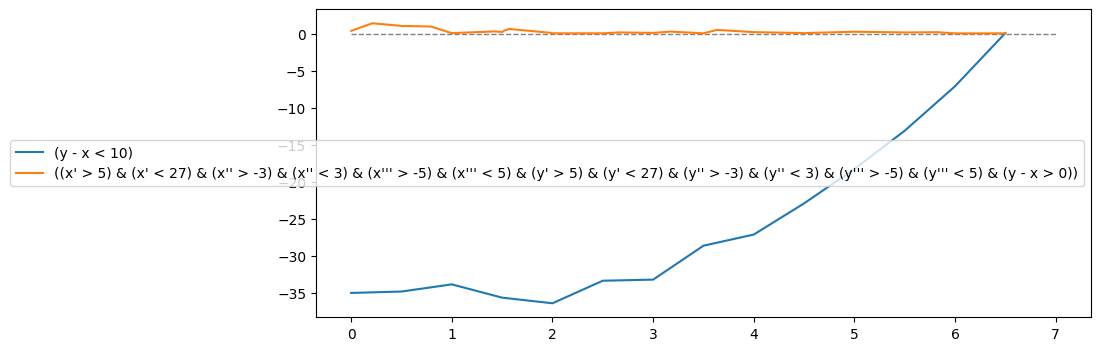

In [144]:
plt.hlines(0, 0, duration, color='gray', linestyle='--', linewidth=1)
plot_robustness(danger, falsified_traces[0])
plot_robustness(carx & cary & (Predicate("y - x") > 0), falsified_traces[0])
plt.legend()
plt.show()

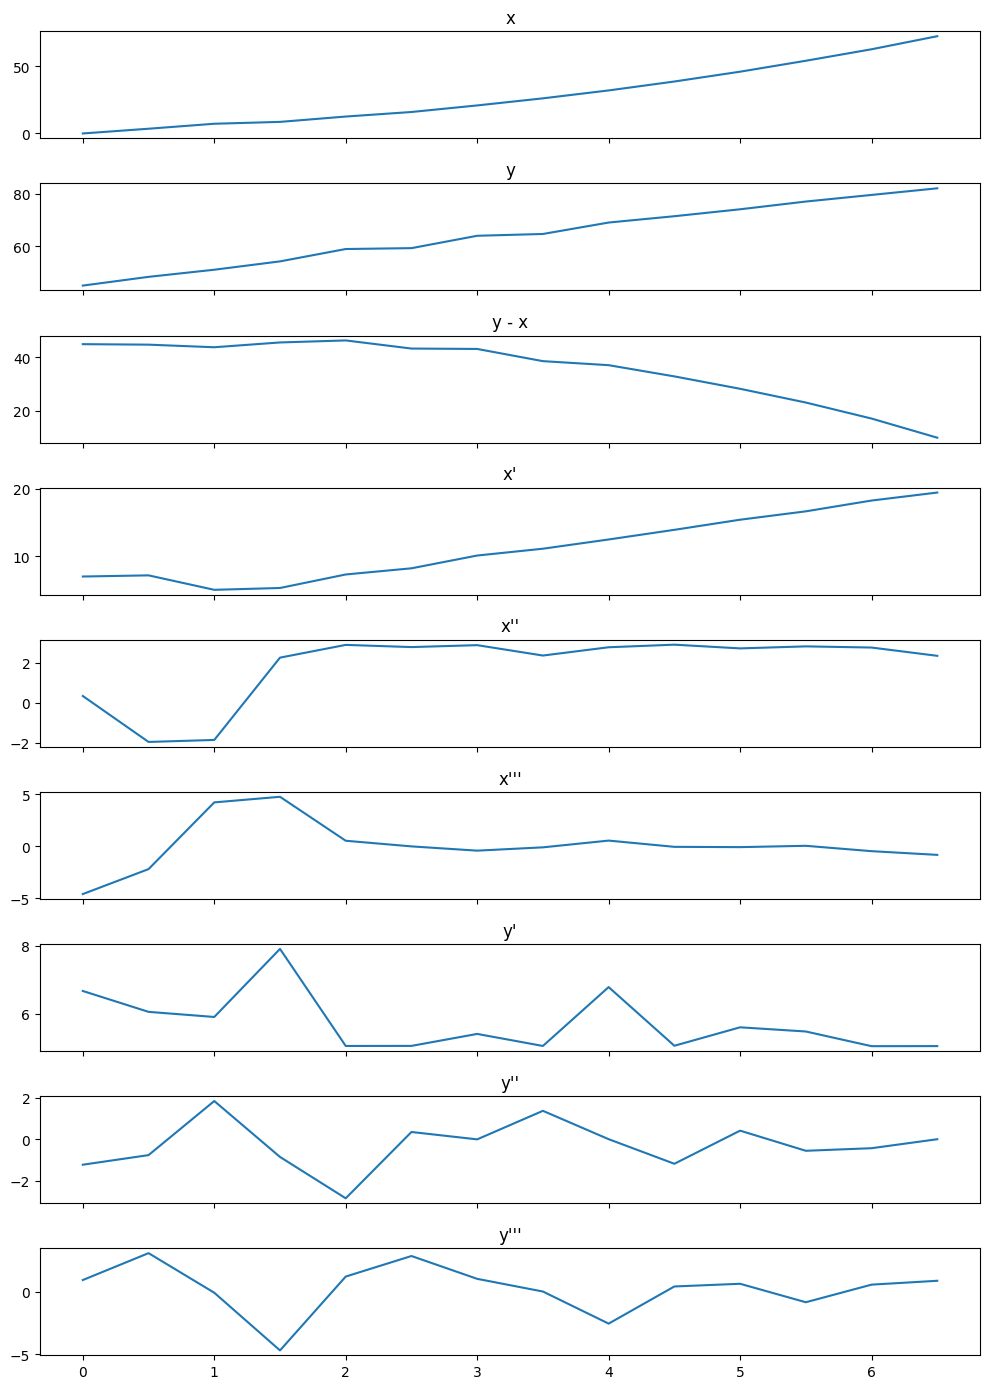

In [145]:
plot_trace(falsified_traces[0], sharey=False, figsize=[10, 14])